In [1]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from gluonts.dataset.common import ListDataset
from sklearn.model_selection import train_test_split

from lag_llama.gluon.estimator import LagLlamaEstimator
from datasets import load_dataset

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [3]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    print(estimator.lags_seq)

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_1033809/3902027965.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU

# Exchange Rate

In [4]:
dataset_er = get_dataset("exchange_rate")

backtest_dataset = dataset_er.test
prediction_length = dataset_er.metadata.prediction_length

In [5]:
print(len(backtest_dataset))
print(prediction_length)

40
30


[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

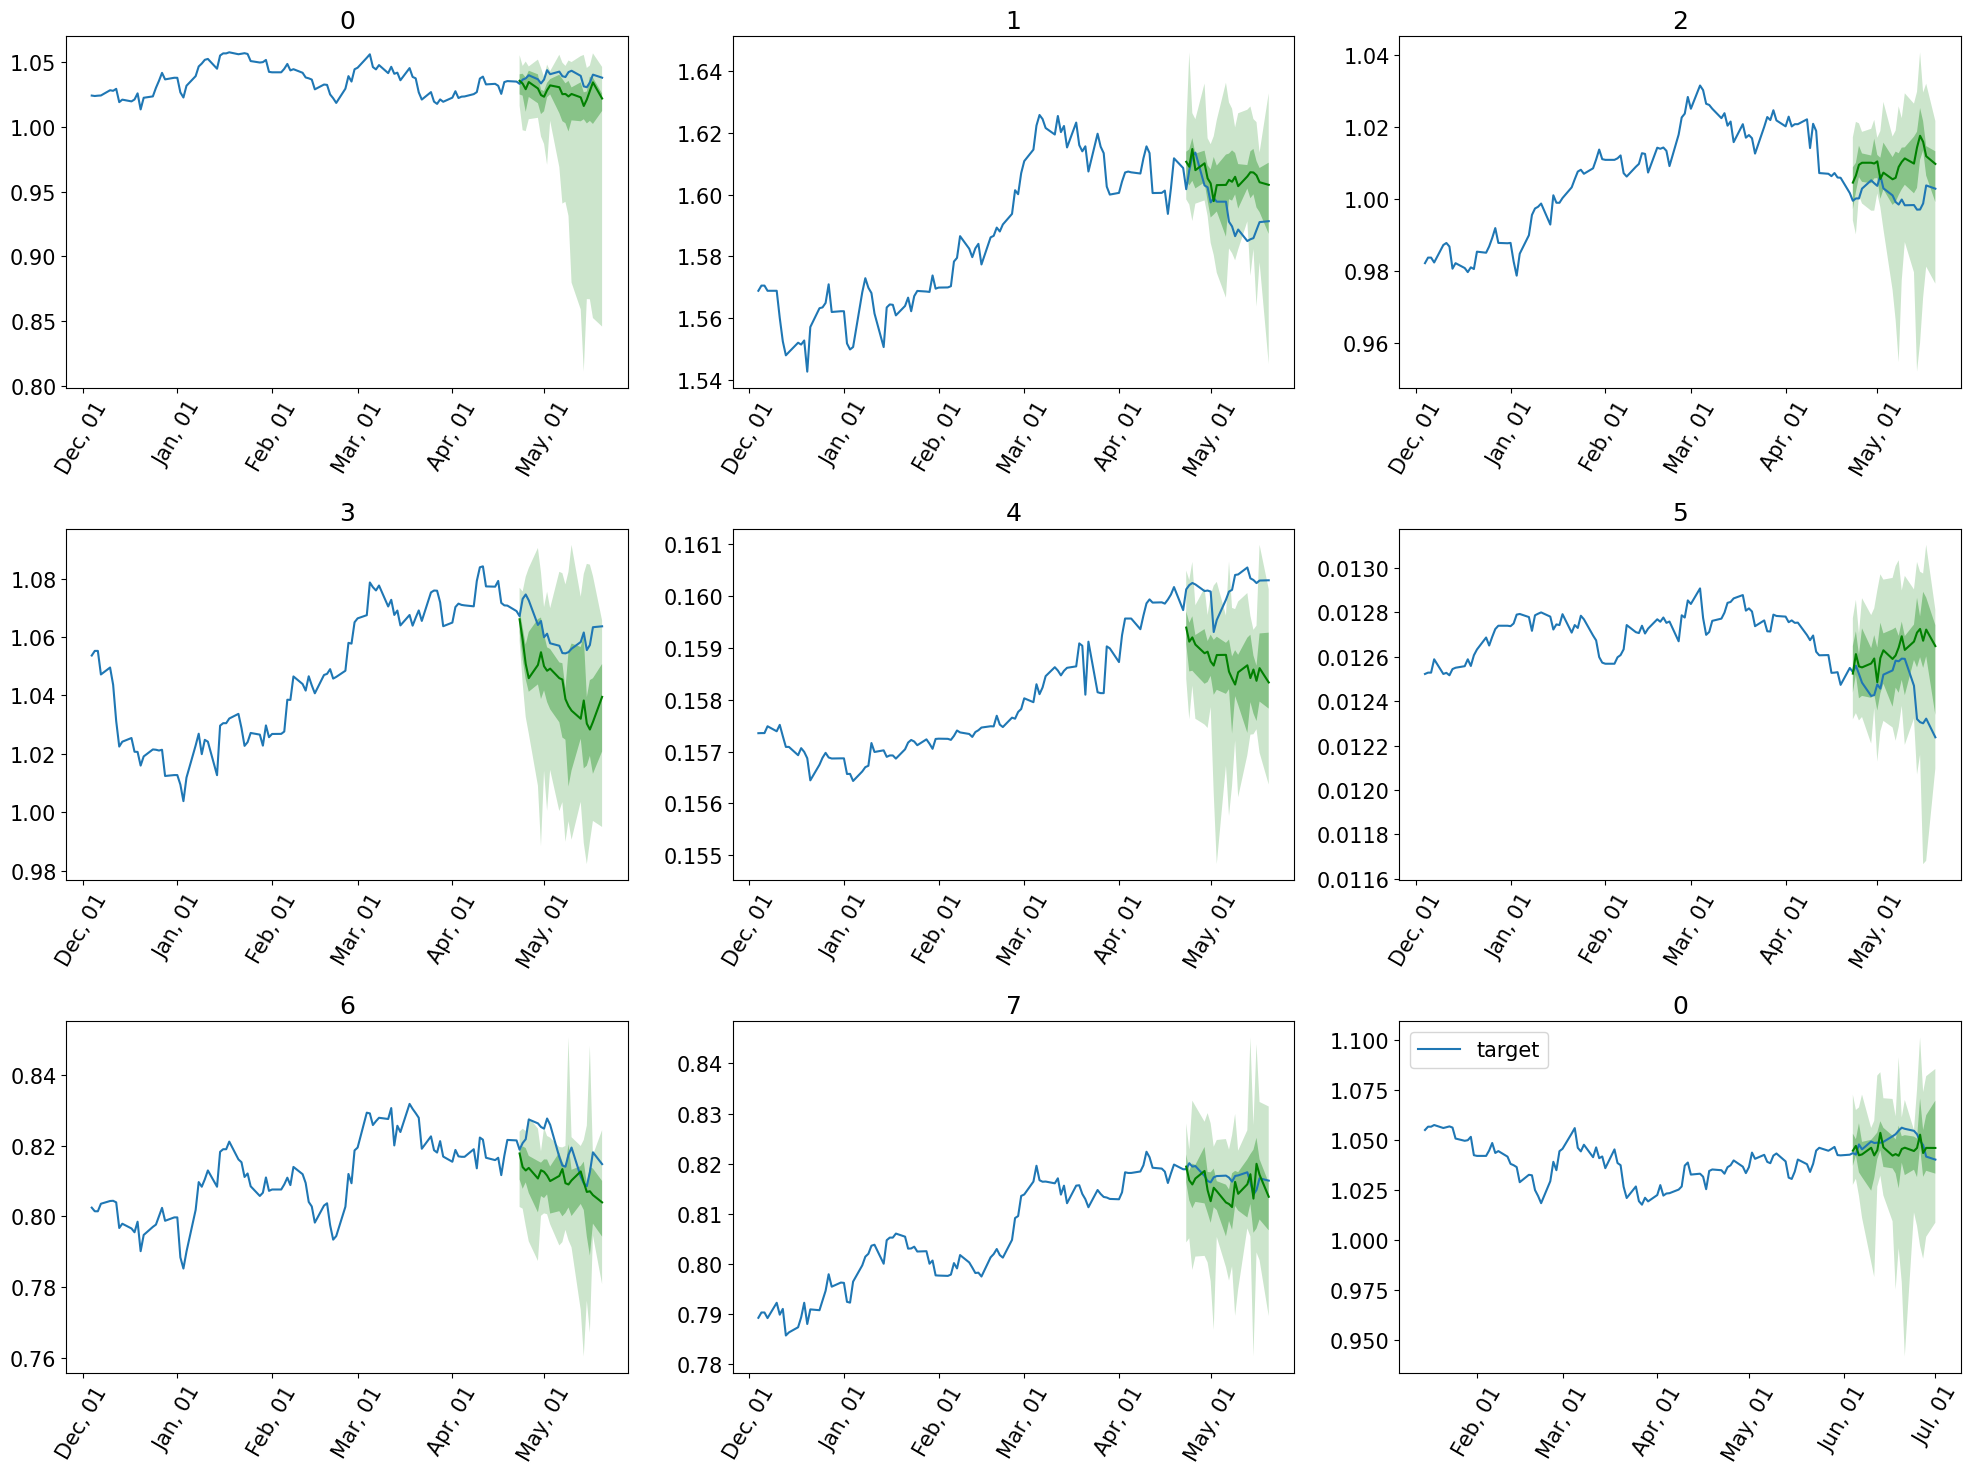

Running evaluation: 40it [00:00, 1589.96it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return _ForkingPickler.loads(res)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex w

CRPS: 0.008233325469796217
WQL: 0.0043255540781211394
MSE: 0.00020557103217797132
MAPE: 0.010609430454205721
RMSE: 0.014337748504488818
MASE: 1.6930810424665368


In [11]:
forecasts_it, tss_it= get_lag_llama_predictions(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# Covid Deaths

In [15]:
dataset_cov = get_dataset("covid_deaths")

backtest_dataset = dataset_cov.test
prediction_length = dataset_cov.metadata.prediction_length

In [16]:
def trim_zeros(dataset, freq):
    filtered_entries = []
    for entry in dataset:
        # Cari posisi pertama nilai non-nol dalam target
        non_zero_idx = next((i for i, x in enumerate(entry['target']) if x != 0), None)
        if non_zero_idx is not None:
            # Potong target mulai dari posisi non-zero pertama
            trimmed_target = entry['target'][non_zero_idx:]
            # Update start time sesuai target yang dipotong
            entry['start'] = entry['start'] + non_zero_idx
            entry['target'] = trimmed_target
            filtered_entries.append(entry)
    return ListDataset(filtered_entries, freq=freq)

# Preprocessing train and test dataset
train_trimmed = trim_zeros(dataset_cov.train, dataset_cov.metadata.freq)
test_trimmed = trim_zeros(dataset_cov.test, dataset_cov.metadata.freq)

In [17]:
print(len(backtest_dataset))
print(prediction_length)

266
30


[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


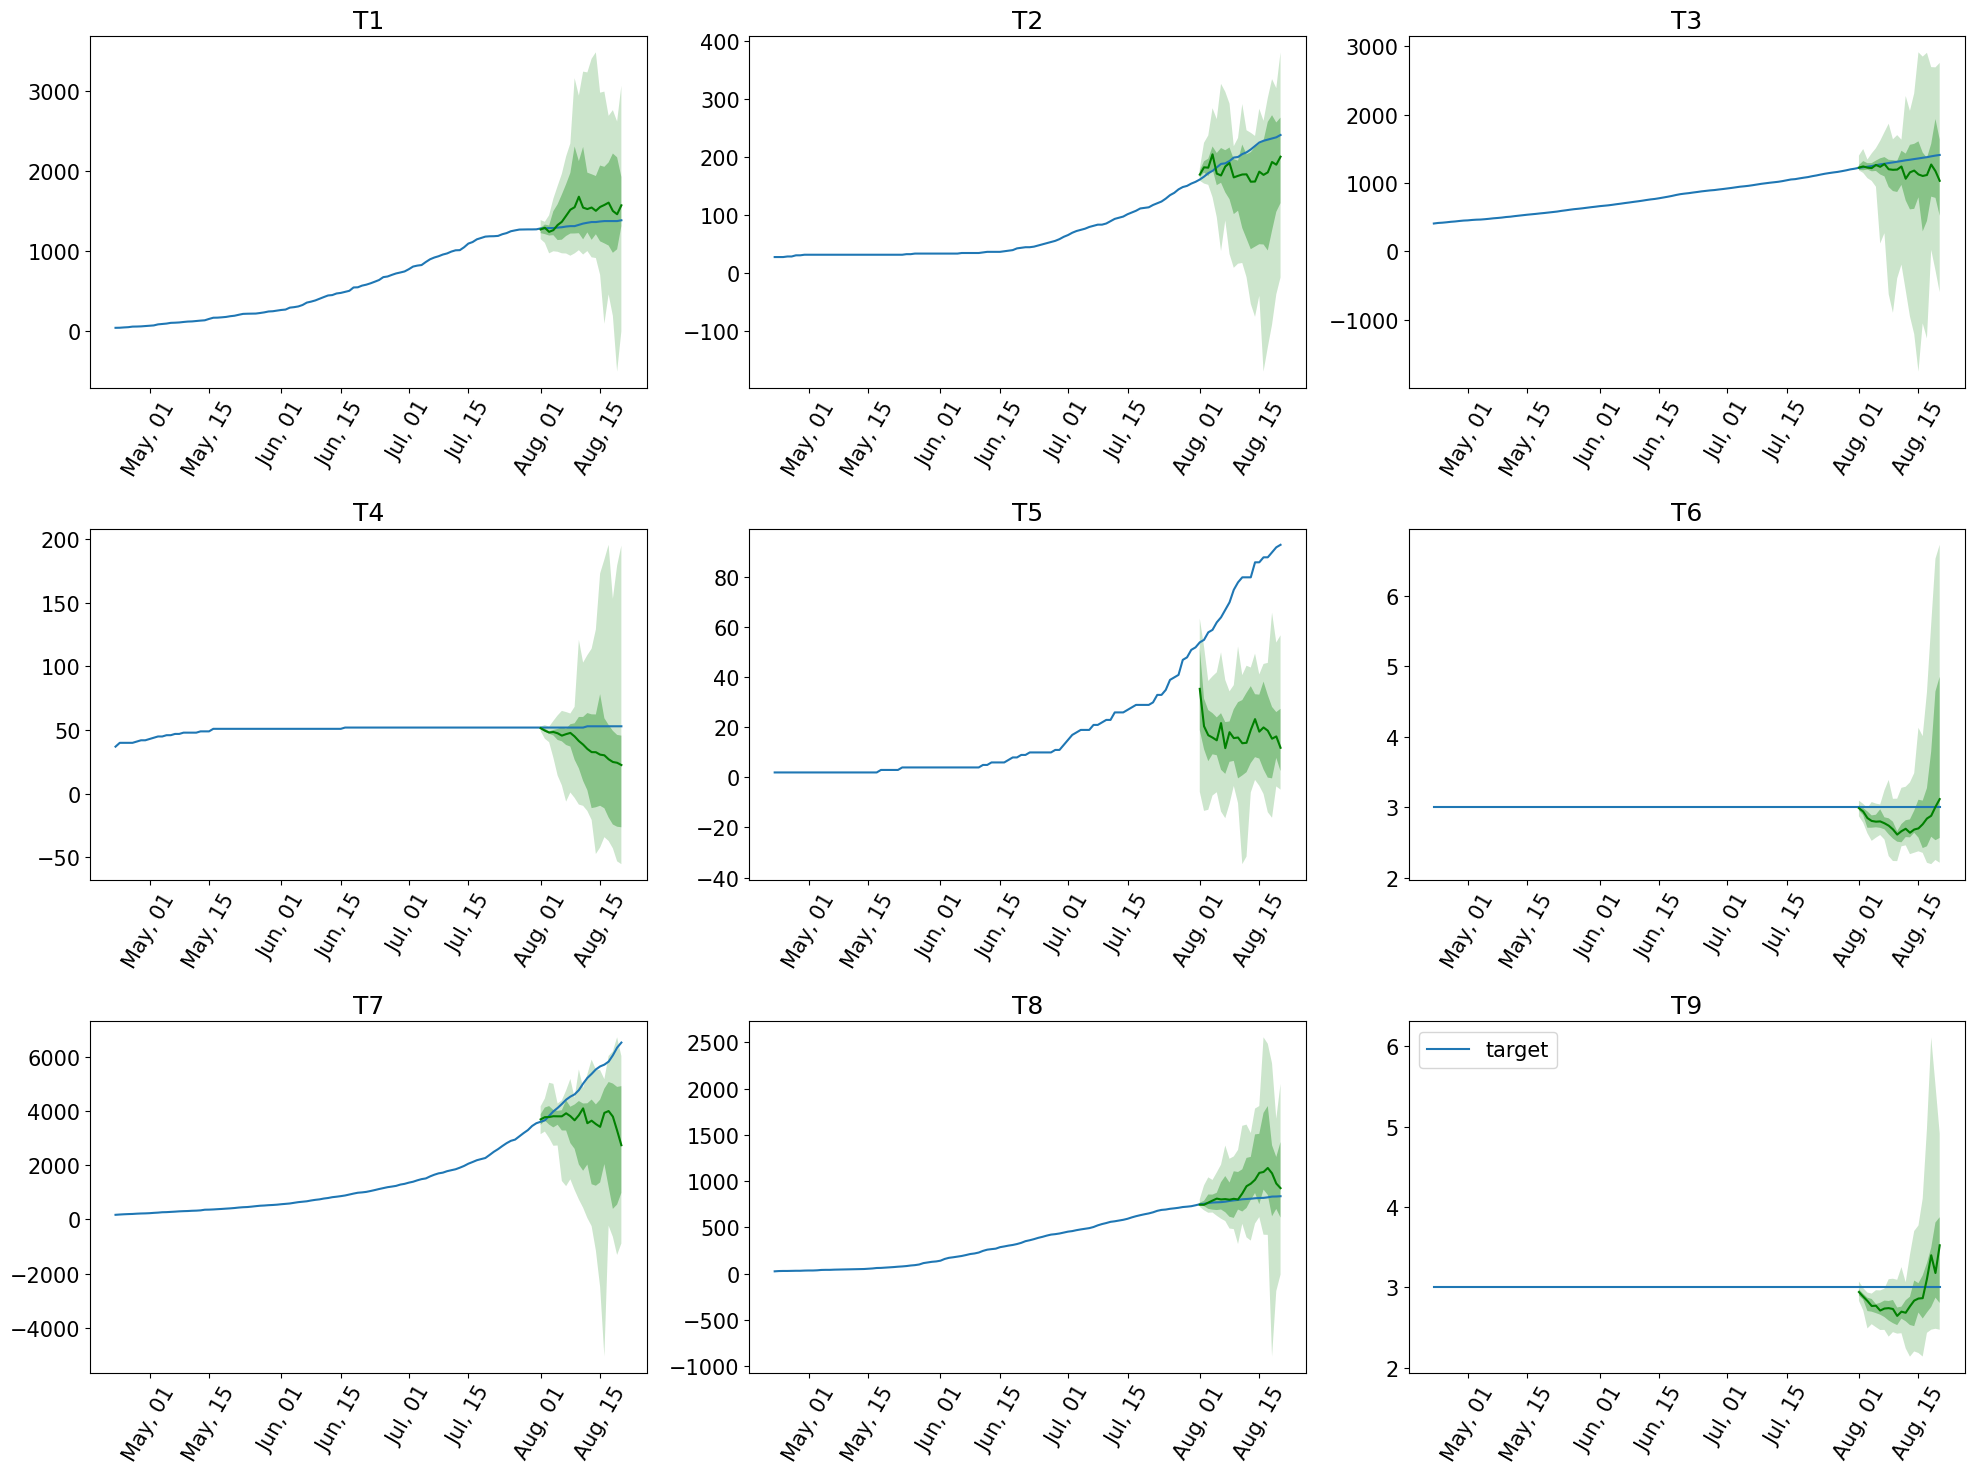

Running evaluation: 266it [00:00, 7566.38it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed 

CRPS: 0.18442434741515198
WQL: 0.09253911628956717
MSE: 16096765.321951194
MAPE: 0.2660217898608796
RMSE: 4012.0774321978374
MASE: inf


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide

In [14]:
forecasts_it, tss_it= get_lag_llama_predictions(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# Traffic

In [4]:
dataset_tr = get_dataset("traffic")

backtest_dataset = dataset_tr.test
prediction_length = dataset_tr.metadata.prediction_length

In [5]:
print(len(backtest_dataset))
print(prediction_length)

6034
24


[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


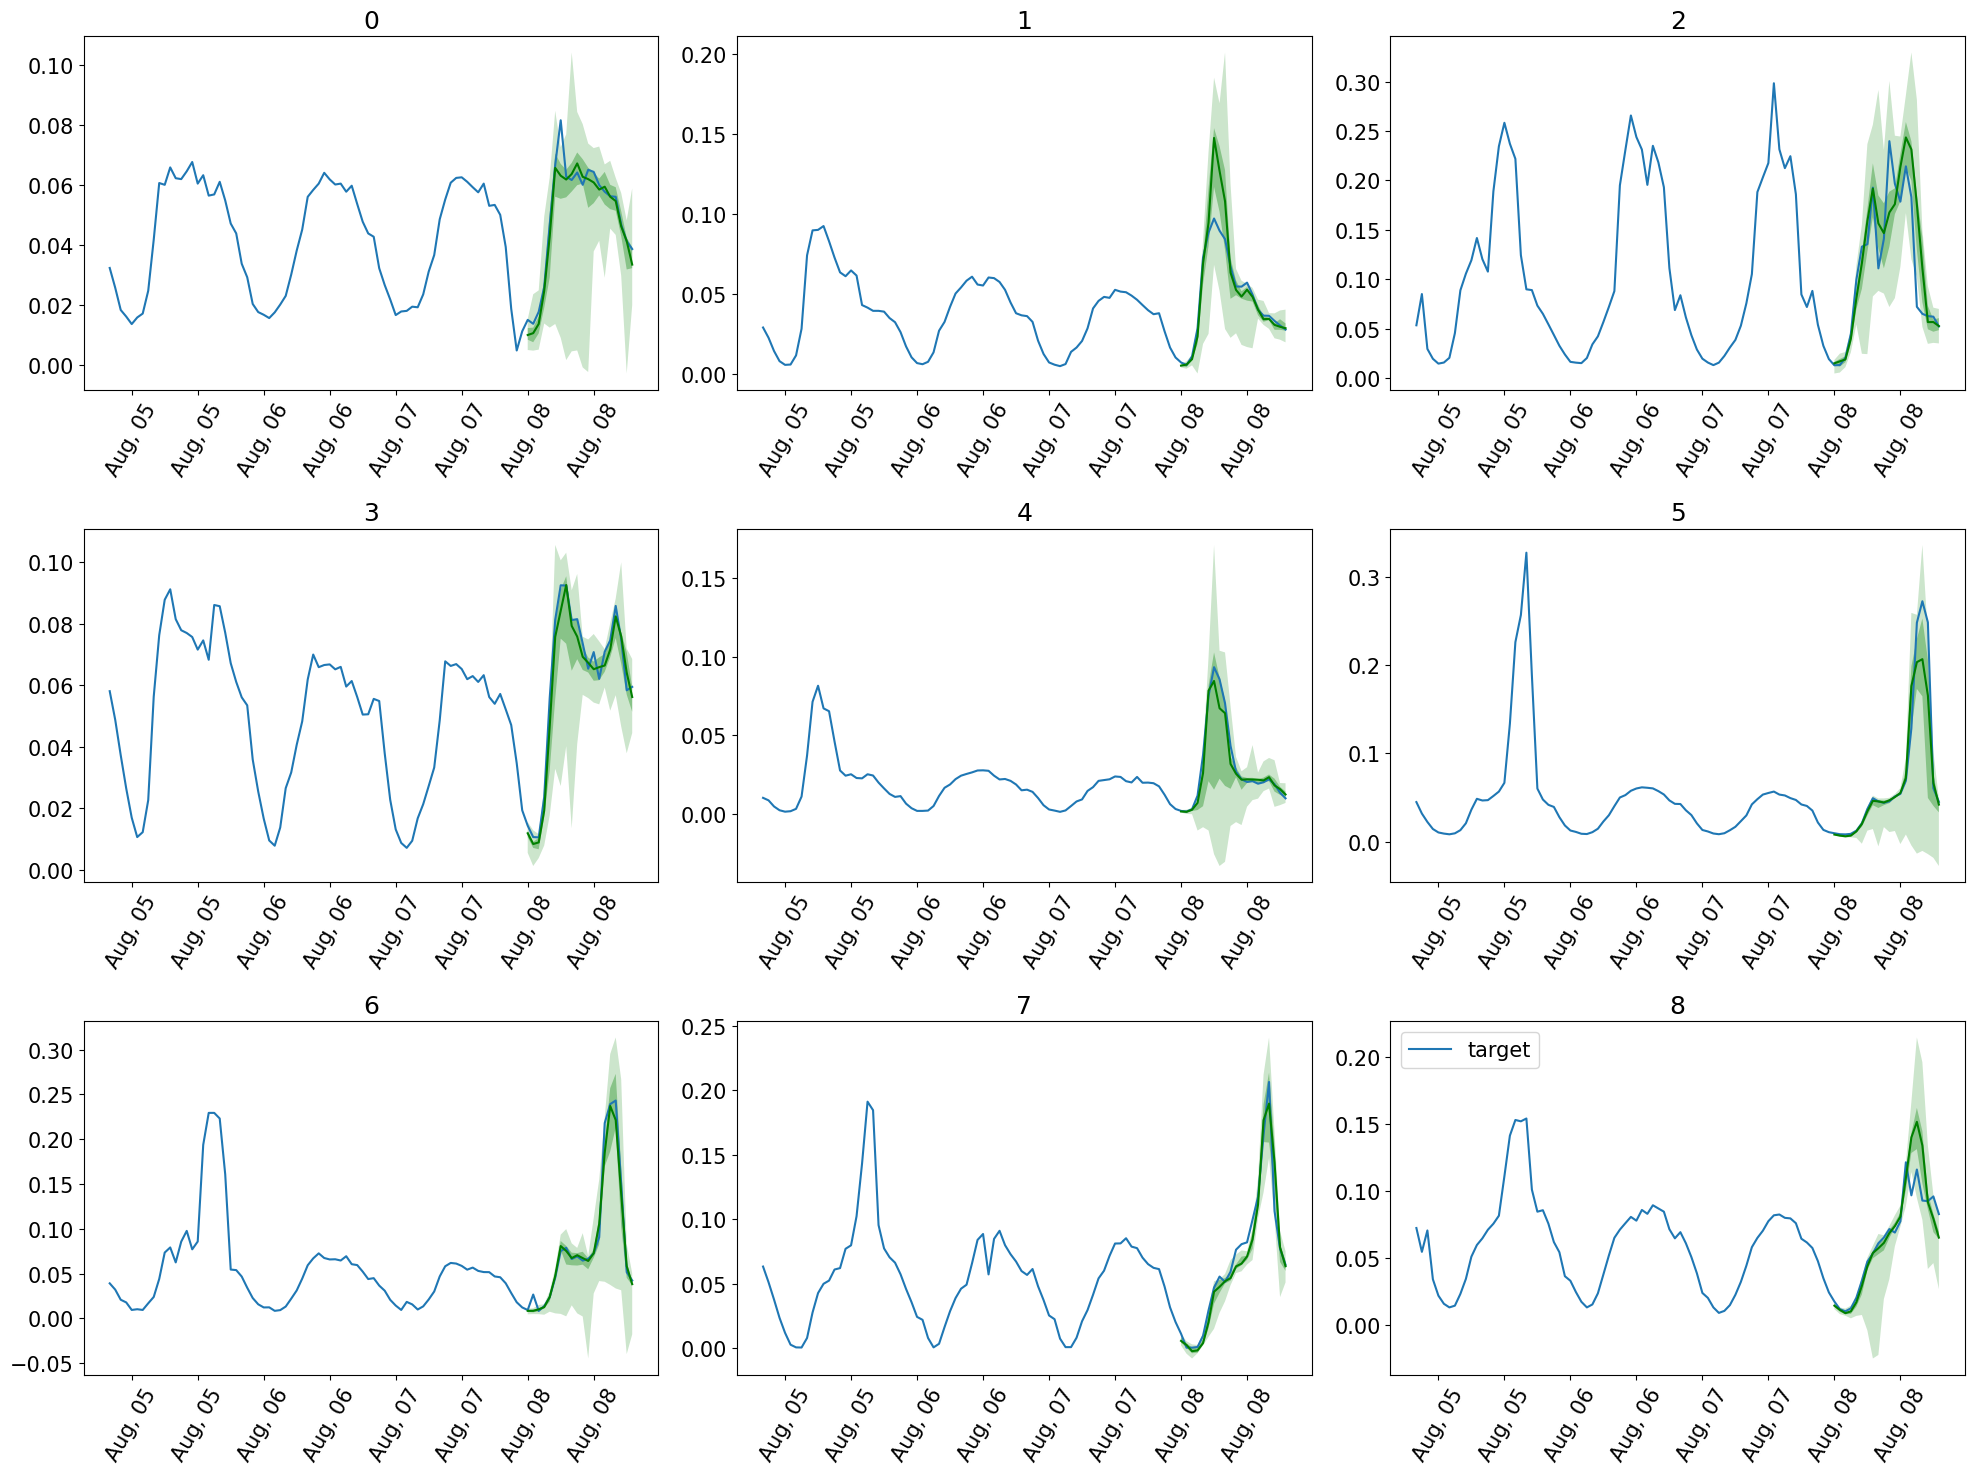

Running evaluation: 6034it [00:00, 155599.60it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to spe

CRPS: 0.13220440358041965
WQL: 0.087183618889097
MSE: 0.0008118082767093908
MAPE: 0.19722871946836495
RMSE: 0.028492249414698564
MASE: 0.646080775839057
{'MSE': 0.0008118082767093908, 'abs_error': 1215.6529777375981, 'abs_target_sum': 7883.297818157822, 'abs_target_mean': 0.06532397926879203, 'seasonal_error': 0.01521843700422631, 'MASE': 0.646080775839057, 'MAPE': 0.19722871946836495, 'sMAPE': 0.17415682557781367, 'MSIS': 9.427685698385737, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 687.2944325675214, 'Coverage[0.1]': 0.036766655618163745, 'QuantileLoss[0.2]': 936.8810708236997, 'Coverage[0.2]': 0.09229366920782235, 'QuantileLoss[0.3]': 1083.6791204954409, 'Coverage[0.3]': 0.17312727875372888, 'QuantileLoss[0.4]': 1172.3796833661472, 'Coverage[0.4]': 0.27137885316539606, 'QuantileLoss[0.5]': 1215.6529788525804, 'Coverage[0.5]': 0.3845210473980775, 'QuantileLoss[0.6]': 1251.8693444697187, 'Coverage[0.6]': 0.44660258534968517, 'QuantileLoss[0.7]': 1183.7915453686933, 'Coverag

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [7]:
forecasts_it, tss_it= get_lag_llama_predictions(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.1]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])
print(agg_metrics)

# Weather

In [13]:
dataset_tr = get_dataset("weather")

backtest_dataset = dataset_tr.test
prediction_length = dataset_tr.metadata.prediction_length

In [14]:
print(len(backtest_dataset))
print(prediction_length)

3010
30


[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


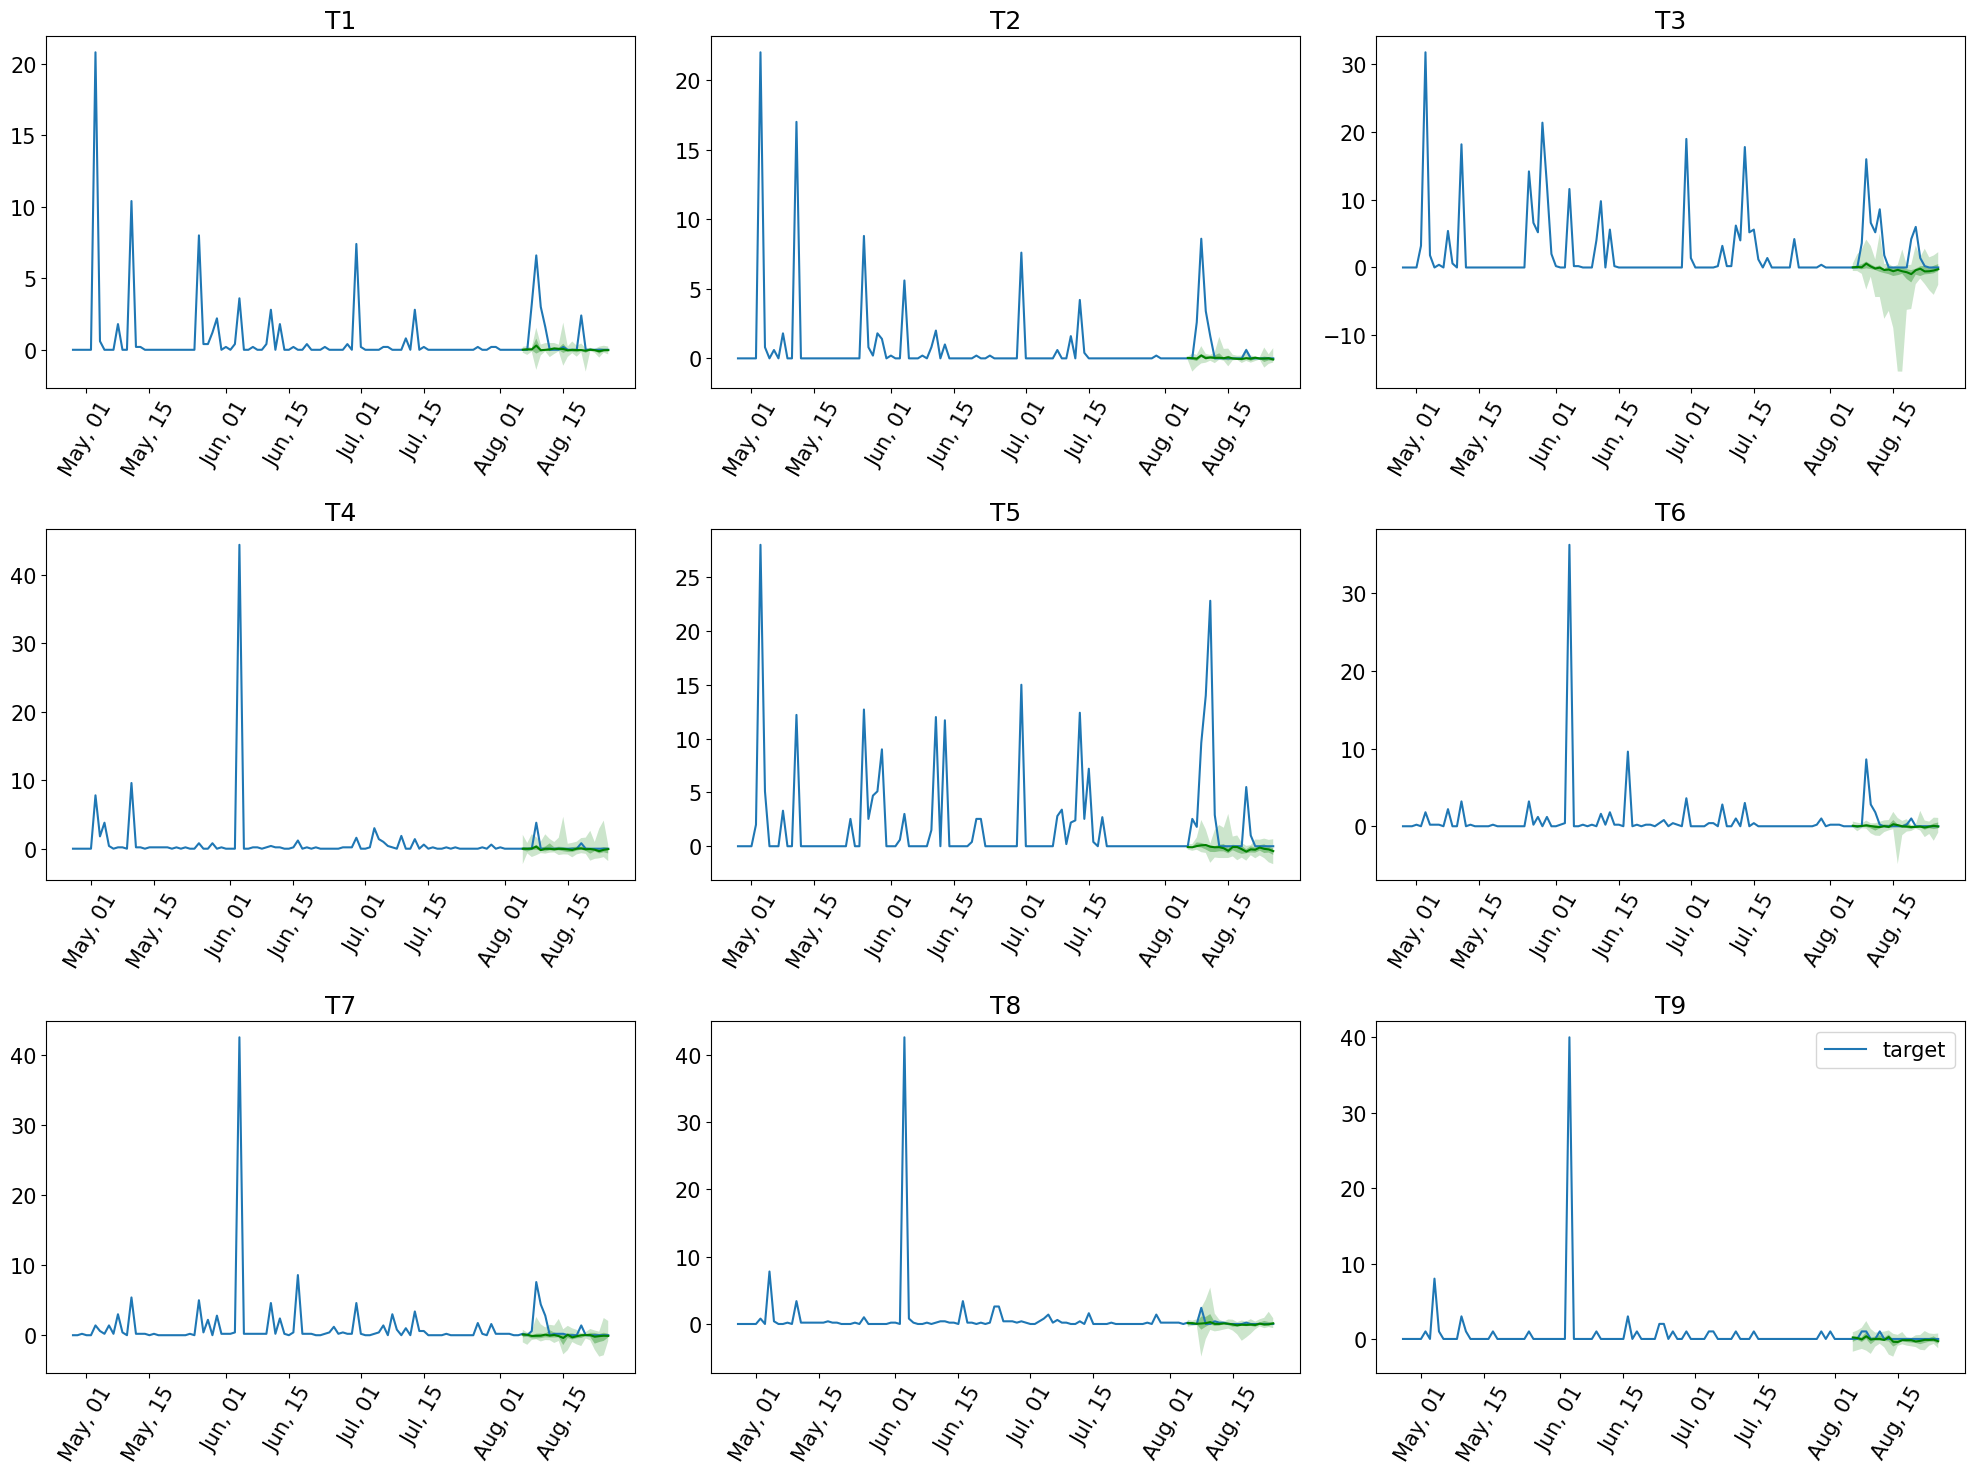

Running evaluation: 3010it [00:00, 18201.79it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, me

CRPS: 0.16201335092980595
WQL: 0.11968213971076981
MSE: 22.22132136952592
MAPE: 0.6785638819113359
RMSE: 4.7139496570843775
MASE: 1.014799635437069


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [15]:
forecasts_it, tss_it= get_lag_llama_predictions(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# Hospital

In [16]:
dataset_tr = get_dataset("hospital")

backtest_dataset = dataset_tr.test
prediction_length = dataset_tr.metadata.prediction_length

In [17]:
print(len(backtest_dataset))
print(prediction_length)

767
12


[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


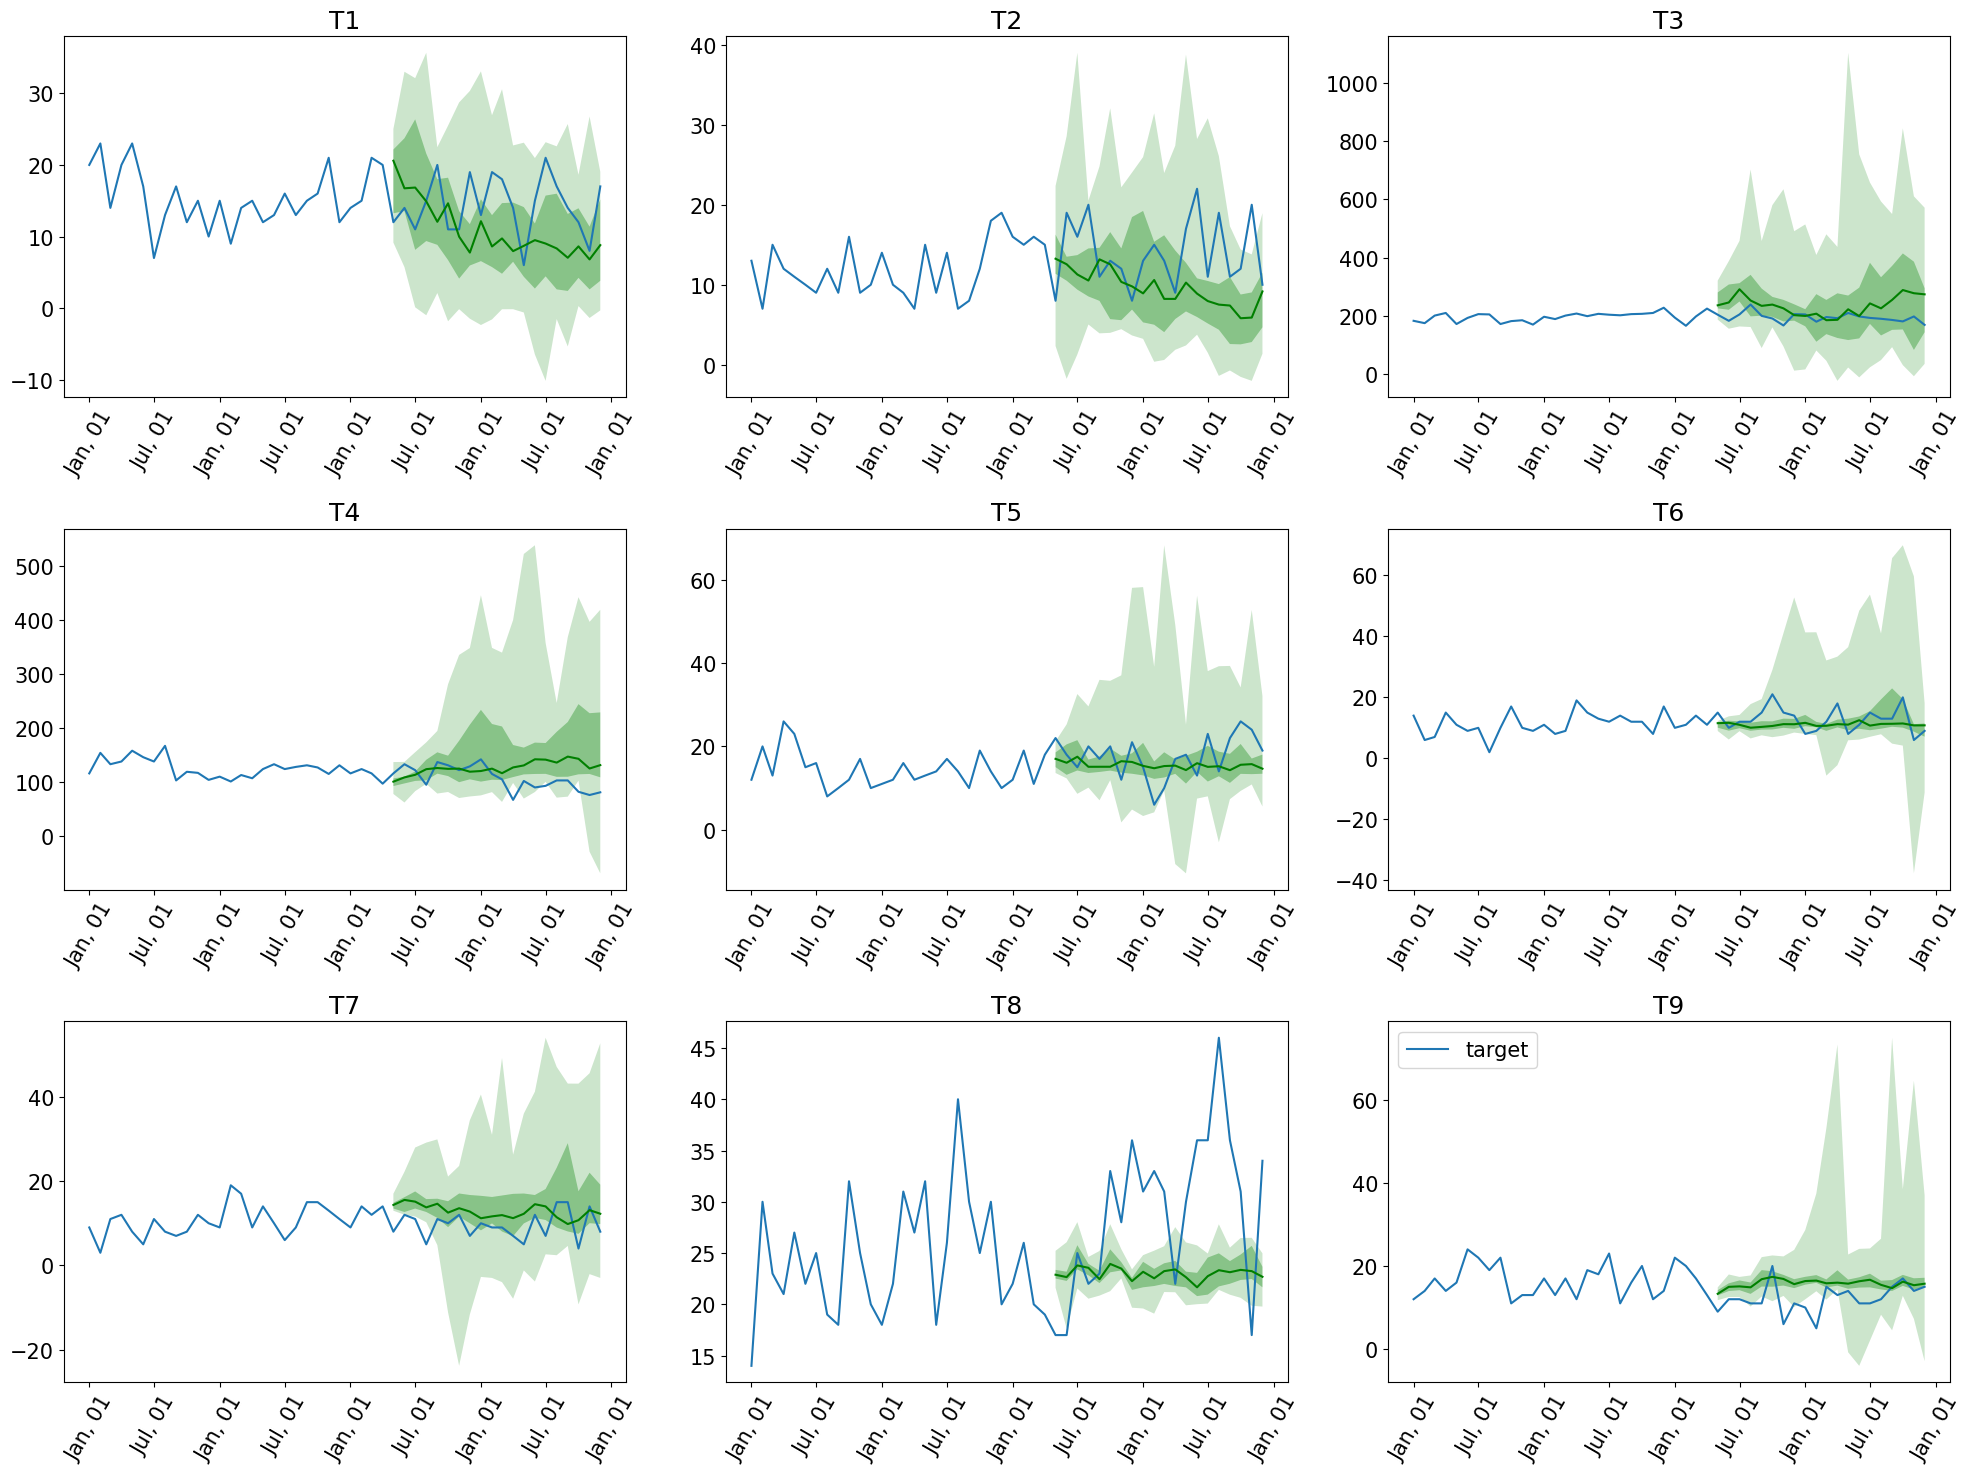

Running evaluation: 767it [00:00, 21308.65it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed

CRPS: 0.10293126700588644
WQL: 0.08409156059089917
MSE: 11970.34613834565
MAPE: 0.2404875676782688
RMSE: 109.40907703817655
MASE: 1.007365855930595


In [18]:
forecasts_it, tss_it= get_lag_llama_predictions(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# RAF

In [6]:
import torch
import numpy as np
from gluonts.model.forecast import SampleForecast
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def find_best_matches_full_series_batch(
    dataset,
    context_tensor_matrix,
    test_length,
    prediction_length,
    top_n,
):
    best_matches = []

    # Menggabungkan semua time series dalam train_df menjadi satu array
    train_series = np.concatenate([entry["target"] for entry in dataset])

    for context_tensor in context_tensor_matrix:
        context = context_tensor[-test_length:].numpy()

        # Inisialisasi variabel untuk menyimpan jarak dan segmen terbaik
        distances = []
        segments = []

        # Iterasi melalui train_series untuk menemukan segmen yang cocok
        for i in range(len(train_series) - test_length - prediction_length + 1):
            train_segment = train_series[i : i + test_length]
            distance = np.linalg.norm(context - train_segment)
            distances.append(distance)
            segments.append(train_series[i + test_length : i + test_length + prediction_length])

        # Mengurutkan segmen berdasarkan jarak terpendek
        sorted_indices = np.argsort(distances)[:top_n]
        best_segments = [segments[idx] for idx in sorted_indices]
        best_matches.extend(best_segments)

    return best_matches


def augment_time_series(dataset, context_tensor_matrix, prediction_length, top_n):
    """
    Fungsi ini melakukan augmentasi pada time series dengan menambahkan segmen terbaik dari data latih ke konteks.
    """
    test_length = len(context_tensor_matrix[0])
    best_matches = find_best_matches_full_series_batch(
        dataset, context_tensor_matrix, test_length, prediction_length, top_n
    )

    augmented_matrix = []
    mean_std_values = []

    for idx, context_tensor in enumerate(context_tensor_matrix):
        context_tensor = torch.tensor(context_tensor, dtype=torch.float32)
        elements = best_matches[idx * top_n : (idx + 1) * top_n]
        avg_best_segment = np.mean(elements, axis=0)
        avg_segment_tensor = torch.tensor(avg_best_segment, dtype=torch.float32)

        # Normalisasi segmen terbaik
        avg_mean = avg_segment_tensor.mean()
        avg_std = avg_segment_tensor.std() + 1e-7
        avg_segment_tensor = (avg_segment_tensor - avg_mean) / avg_std

        # Normalisasi konteks
        context_mean = context_tensor.mean()
        context_std = context_tensor.std() + 1e-7
        context_tensor = (context_tensor - context_mean) / context_std

        # Penyesuaian perbedaan antara awal konteks dan akhir segmen terbaik
        context_start = context_tensor[0] if not torch.isnan(context_tensor[0]) else 0
        best_segment_start = avg_segment_tensor[-1]
        difference = context_start - best_segment_start
        avg_segment_tensor += difference

        # Penggabungan segmen terbaik dengan konteks
        augmented_tensor = torch.cat((avg_segment_tensor, context_tensor))
        augmented_matrix.append(augmented_tensor)
        mean_std_values.append((context_mean, context_std))

    return augmented_matrix, mean_std_values

def normalize_context(context_tensor_matrix):
    """
    Fungsi ini melakukan normalisasi pada setiap tensor dalam context_tensor_matrix.
    """
    normalized_context = []
    mean_std_values = []

    for context_tensor in context_tensor_matrix:
        context_tensor = torch.tensor(context_tensor, dtype=torch.float32)
        context_mean = context_tensor.mean()
        context_std = context_tensor.std() + 1e-7
        normalized_tensor = (context_tensor - context_mean) / context_std
        normalized_context.append(normalized_tensor)
        mean_std_values.append((context_mean, context_std))

    return normalized_context, mean_std_values

def denormalize_predictions(predictions, mean_std_values):
    """
    Fungsi ini mengembalikan prediksi yang telah dinormalisasi ke skala aslinya.
    """
    denormalized_predictions = []

    for idx, prediction in enumerate(predictions):
        mean, std = mean_std_values[idx]
        samples = torch.tensor(prediction.samples)
        denormalized_prediction = samples * std + mean
        denormalized_forecast = SampleForecast(
            samples=denormalized_prediction.numpy(),
            start_date=prediction.start_date,
            item_id=prediction.item_id,
            info=prediction.info
        )
        denormalized_predictions.append(denormalized_forecast)

    return denormalized_predictions


In [ ]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def generate_lag_llama_forecasts(
    dataset,
    prediction_length,
    context_length=32,
    use_rope_scaling=False,
    num_samples=100,
    augment=False,
    top_n=1,
    device=device,
):

    # Menyiapkan argumen untuk RoPE scaling jika diperlukan
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    } if use_rope_scaling else None

    # Inisialisasi estimator Lag-Llama
    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments,
        batch_size=1,
        num_parallel_samples=num_samples,
        device=device,
    )

    # Membuat modul Lightning dan transformasi
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    # Menyiapkan data untuk prediksi
    context_tensor_matrix = [torch.tensor(entry["target"], dtype=torch.float32) for entry in dataset]

    if augment:
        # Proses augmentasi menggunakan RAF
        context_tensor_matrix, mean_std_values = augment_time_series(
            dataset, context_tensor_matrix, prediction_length, top_n
        )
        print('context_tensor_matrix:', context_tensor_matrix)
        print('mean_std_values:', mean_std_values)
    else:
        # Normalisasi konteks tanpa augmentasi
        context_tensor_matrix, mean_std_values = normalize_context(context_tensor_matrix)
        
    evaluation_dataset = [
        {
            "start": entry["start"],
            "target": context_tensor.numpy(),
        }
        for entry, context_tensor in zip(dataset, context_tensor_matrix)
    ]

    # Melakukan prediksi
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=evaluation_dataset,
        predictor=predictor,
        num_samples=num_samples,
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    # Denormalisasi hasil prediksi jika diperlukan
    if augment:
        forecasts = denormalize_predictions(forecasts, mean_std_values)
        print(forecasts)

    return forecasts, tss


/tmp/ipykernel_1033809/1638233653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)


# Exchange Rate RAF

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/tmp/ipykernel_1029875/58521174

context_tensor_matrix: [tensor([-3.6595, -3.7138, -2.6660,  ...,  1.9921,  2.0359,  2.0189]), tensor([-3.8554, -3.8821, -1.9450,  ..., -0.4516, -0.4356, -0.4337]), tensor([-2.9031, -2.9649, -1.6070,  ...,  1.5374,  1.5790,  1.5715]), tensor([-2.7300, -1.8216, -0.2014,  ...,  1.7674,  1.8088,  1.8109]), tensor([5.3509, 4.9877, 5.4102,  ..., 0.8467, 0.8487, 0.8489]), tensor([-1.3309, -2.3721, -1.1966,  ...,  1.8971,  1.9105,  1.8568]), tensor([-3.4267, -3.8278, -3.2068,  ...,  1.7079,  1.7595,  1.7287]), tensor([-3.8599, -3.5177, -2.1985,  ...,  2.2317,  2.2627,  2.2565]), tensor([-2.0876, -2.1213, -2.3740,  ...,  2.0618,  2.0199,  2.0091]), tensor([-0.6332, -0.2238, -0.6033,  ..., -0.2114, -0.2757, -0.2720]), tensor([-1.1896, -1.4816, -1.8191,  ...,  1.6312,  1.5800,  1.5890]), tensor([-1.6146, -1.5944, -1.0472,  ...,  2.0012,  1.9685,  1.9809]), tensor([-0.1024,  0.3593, -0.4539,  ...,  0.8487,  0.8513,  0.8482]), tensor([1.6299, 1.6243, 0.9895,  ..., 1.5963, 1.6167, 1.6065]), tensor([

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = pd.period_range(start, periods=length, freq=start.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/split.py:150: FutureWarning: Pe

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[1.0271537 , 1.016937  , 1.0285954 , 1.0242609 , 1.0293851 ,
        1.0383723 , 1.0344658 , 1.0368652 , 1.0313251 , 1.0374727 ,
        1.0398071 , 1.0311235 , 1.0274932 , 1.0374119 , 1.0595746 ,
        1.0386657 , 1.0220003 , 1.0165907 , 0.99172753, 0.9739903 ],
       [1.043783  , 1.0350654 , 1.0335705 , 1.04036   , 1.0224063 ,
        1.0228429 , 1.0327821 , 1.0150385 , 1.0669887 , 1.0498962 ,
        1.0290191 , 1.0301235 , 1.0456911 , 1.0382514 , 1.02706   ,
        1.0232699 , 1.030406  , 1.0282032 , 1.0258824 , 1.0263977 ],
       [1.0198598 , 1.0227122 , 1.0393076 , 1.048254  , 1.0335475 ,
        1.0206723 , 1.0311875 , 1.0230947 , 1.0317843 , 1.0458078 ,
        1.0354978 , 1.016703  , 1.0166186 , 1.0338024 , 1.0401425 ,
        1.0203209 , 1.0247285 , 1.0356839 , 1.0056235 , 1.006639  ],
       [1.0327376 , 1.0269883 , 1.0373591 , 1.0217631 , 1.0006737 ,
        0.99931186, 0.9987795 , 1.0109265

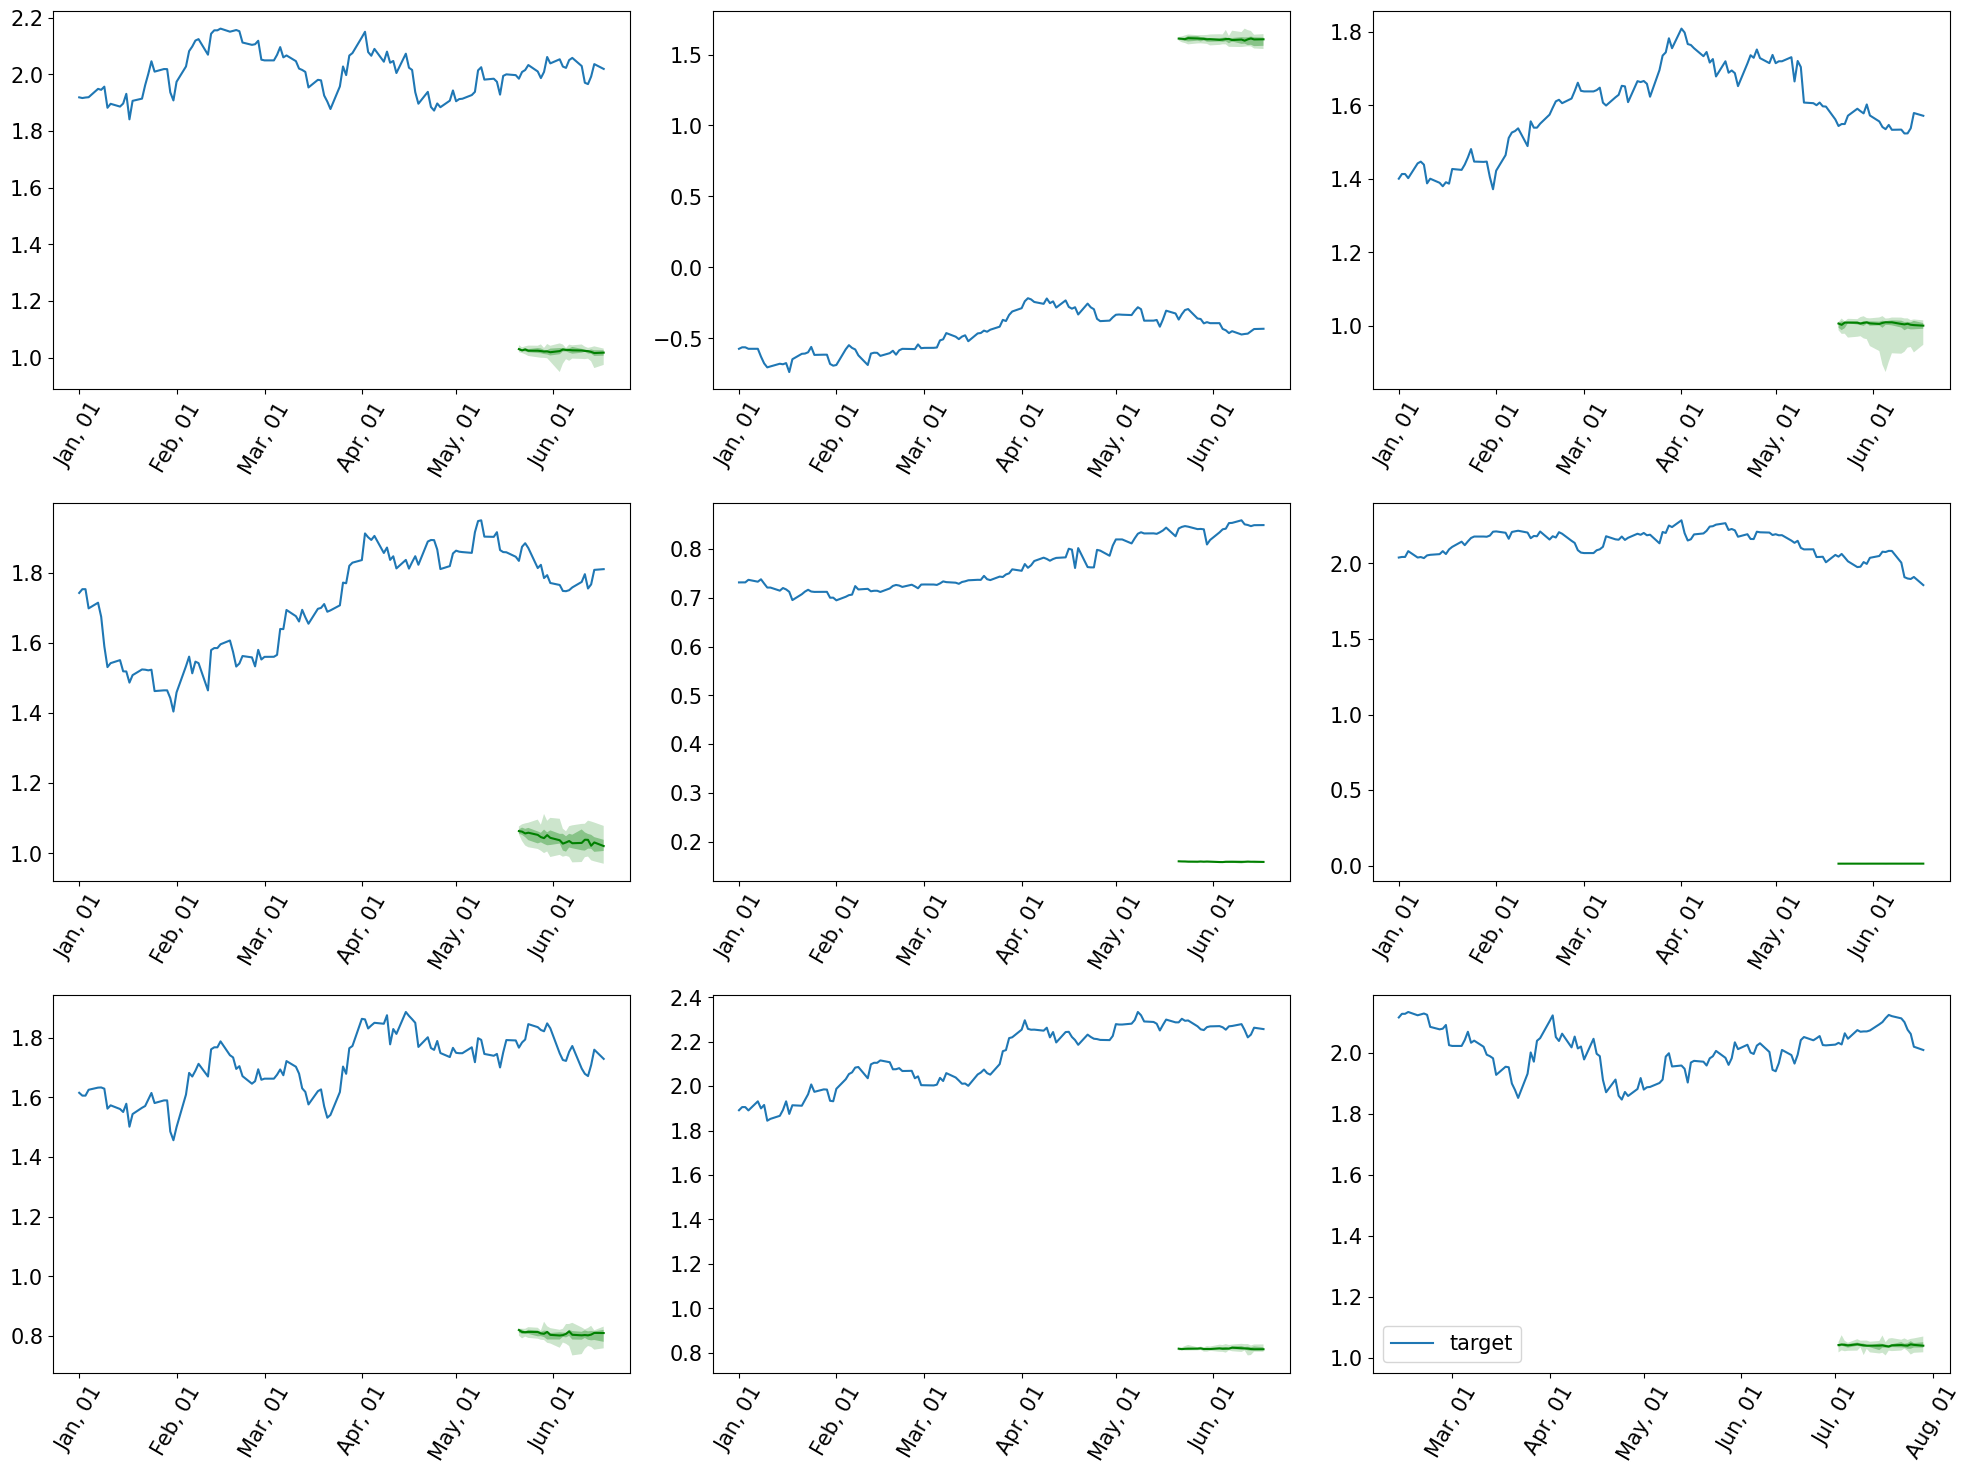

Running evaluation: 40it [00:00, 973.70it/s]


CRPS: 0.7210322408720695
WQL: 1.0073334303102937
MSE: 1.4515854424238204
MAPE: 1.105519332289696
RMSE: 1.204817597158931
MASE: 22.054253413450347


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return _ForkingPickler.loads(res)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return _ForkingPickle

In [10]:
forecasts_it, tss_it= generate_lag_llama_forecasts(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, augment = True, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# Covid Deaths RAF

# Traffic RAF

In [ ]:
forecasts_it, tss_it= generate_lag_llama_forecasts(backtest_dataset, context_length = 75, prediction_length = 20, device = device, num_samples = 20, augment = True, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
